### Identify receptor with conserved important for early-stage AT2-KRAS transformation

In [1]:
import os
import glob
import scanpy as sc
import scanpy.external as sce
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from seaborn import despine
from seaborn import axes_style
import magic # imputation tool; van Dijk et al 2018 # 
from matplotlib.pyplot import suptitle
import matplotlib.colors
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Patch # for clustermap legends
import time

sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

/home/alm72/.conda/envs/KPYtimecourse/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


#### Load mouse, organoid, and human data

In [2]:
# MOUSE
subset_results_file = 'path/to/h5ad'
mouse = sc.read(subset_results_file)

# ORGANOID
at2_results_file = 'path/to/h5ad'
orgs = sc.read(at2_results_file)

# HUMAN
results_file2 = 'path/to/h5ad'
human = sc.read(results_file2)

/home/alm72/.conda/envs/KPYtimecourse/lib/python3.8/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/alm72/.conda/envs/KPYtimecourse/lib/python3.8/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


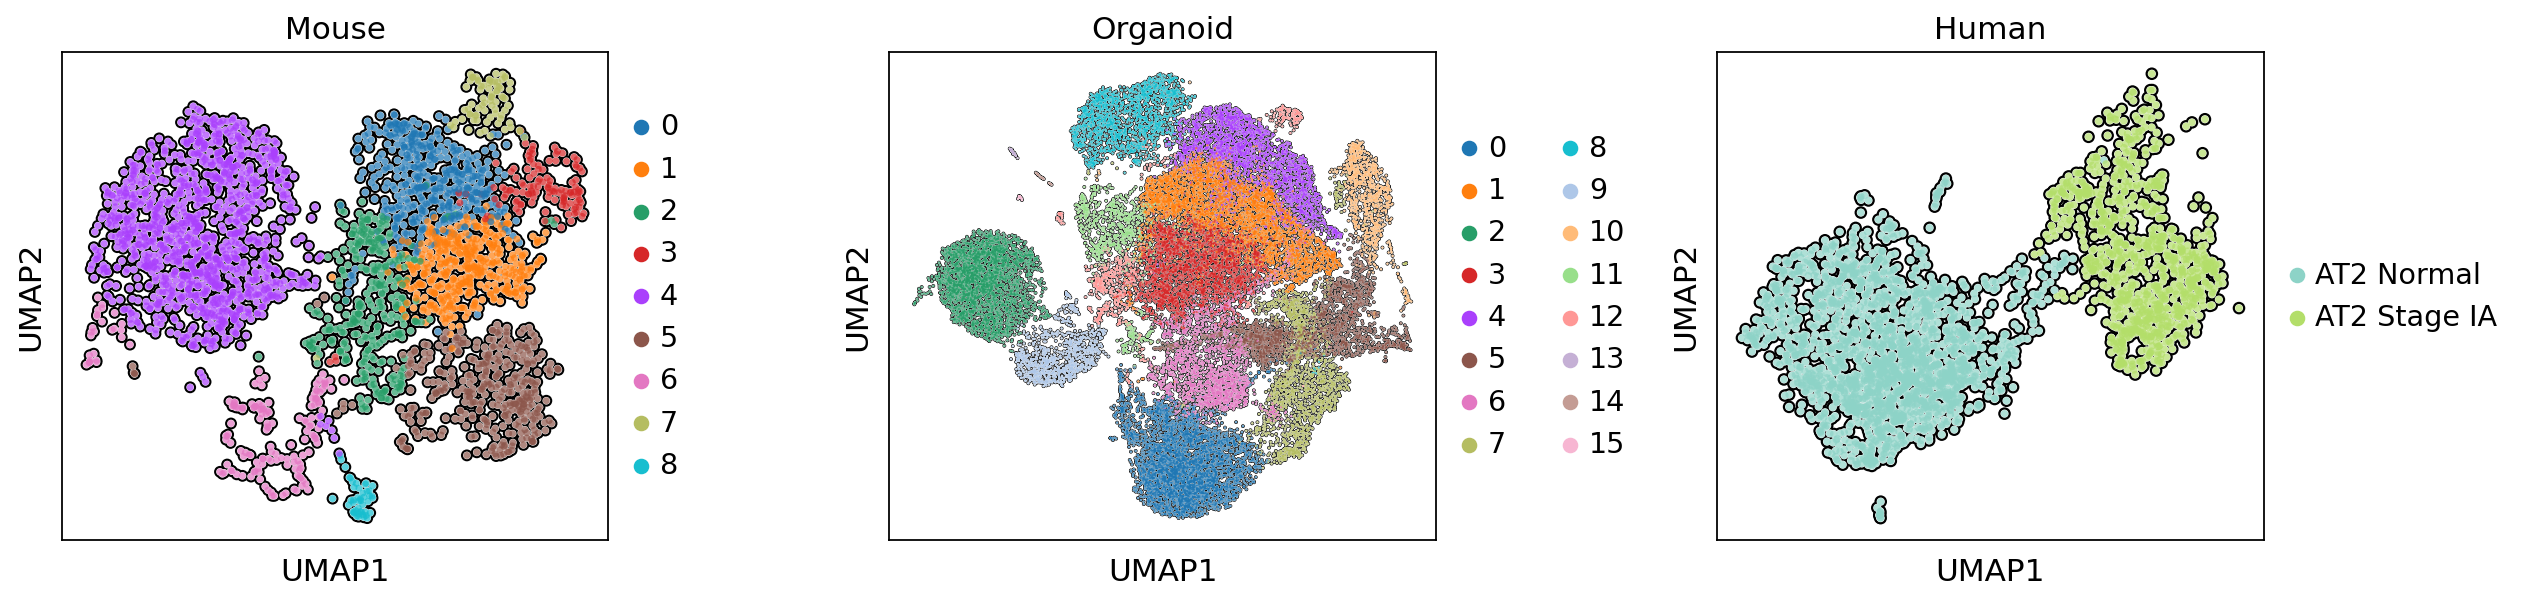

In [4]:
# Create a figure and a grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,4))

sc.set_figure_params(figsize=(4,3), facecolor='white')

# Plot the UMAP plots
sc.pl.umap(mouse, color=['cell_annotations'], add_outline=True, frameon=True, ax=axes[0], show=False, title='Mouse')
sc.pl.umap(orgs, color=['leiden0_2'], add_outline=True, frameon=True, ax=axes[1], show=False, title = 'Organoid')
sc.pl.umap(human, color=['annot'], add_outline=True, frameon=True, ax=axes[2], show=False, title = 'Human', palette=['#8dd3c7', '#b3de69']) # match colors

# Display the figure
plt.tight_layout()
plt.show()

In [5]:
result = mouse.uns['rank_genes_cell_annotations']
groups = result['names'].dtype.names
de_data = pd.DataFrame({group + '_' + key[:1]: result[key][group] for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})
de_data.to_excel("/n/data2/bch/hemonc/ckim/AARON/20190715_KPY_timecourse/data_analysis/organoids/Differential Expression Results/Mouse_leiden_DEGs.xlsx", sheet_name='Sheet1')

<ipython-input-5-51551a207c4b>:4: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  de_data.to_excel("/n/data2/bch/hemonc/ckim/AARON/20190715_KPY_timecourse/data_analysis/organoids/Differential Expression Results/Mouse_leiden_DEGs.xlsx", sheet_name='Sheet1')


In [6]:
result = orgs.uns['rank_genes_leiden0_2']
groups = result['names'].dtype.names
de_data = pd.DataFrame({group + '_' + key[:1]: result[key][group] for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})
de_data.to_excel("/n/data2/bch/hemonc/ckim/AARON/20190715_KPY_timecourse/data_analysis/organoids/Differential Expression Results/Organoids_all_leiden_DEGs.xlsx", sheet_name='Sheet1')

<ipython-input-6-d5edcc366b87>:4: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  de_data.to_excel("/n/data2/bch/hemonc/ckim/AARON/20190715_KPY_timecourse/data_analysis/organoids/Differential Expression Results/Organoids_all_leiden_DEGs.xlsx", sheet_name='Sheet1')


In [7]:
result = human.uns['rank_genes_annot']
groups = result['names'].dtype.names
de_data = pd.DataFrame({group + '_' + key[:1]: result[key][group] for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})
de_data.to_excel("/n/data2/bch/hemonc/ckim/AARON/20190715_KPY_timecourse/data_analysis/organoids/Differential Expression Results/human_AT2_leiden_DEGs.xlsx", sheet_name='Sheet1')

<ipython-input-7-25fcdd6264e3>:4: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  de_data.to_excel("/n/data2/bch/hemonc/ckim/AARON/20190715_KPY_timecourse/data_analysis/organoids/Differential Expression Results/human_AT2_leiden_DEGs.xlsx", sheet_name='Sheet1')


#### Find DE receptors in receptors in each model system

In [43]:
# import receptor list (Skelly 2018 Cell Reports)
receptors = pd.read_excel('/n/data2/bch/hemonc/ckim/AARON/20190715_KPY_timecourse/data_analysis/mice/scanpy_analysis/pinto_receptors_ligands.xlsx',
header=0)

rec_dict = {}
pval = 0.05

''' MOUSE '''

print('#### MOUSE ####')

# Create set of receptors
rec_set = set(receptors['receptor_symbol']) # set faster than list
print('Number of receptors',len(rec_set))

# DE reload data
result = mouse.uns['rank_genes_cell_annotations']
groups = result['names'].dtype.names
de_data = pd.DataFrame({group + '_' + key[:1]: result[key][group] for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})

# create list of cluster names and sort numerically
clusters = sorted(set(mouse.obs.cell_annotations), key=int)

# Filter for significant DE genes, then visualize

for i in clusters:
    df1 = de_data.loc[(de_data[f'{i}_p'] < pval), [f'{i}_n',f'{i}_p',f'{i}_l']] 
    df1 = df1.sort_values(by=f'{i}_l', ascending=False) # sort by log fold value
    top = df1[f'{i}_n'].tolist() # will be order by p val
    print(f'Total sig genes in cluster {i} with pval<{pval}:', len(top))
    top = [x for x in top if x in rec_set] 
    print(f'Total sig receptors in cluster{i} with pval<{pval}:', len(top))
    rec_dict.update({f'Mouse cluster {i} receptors': top})
    
''' ORGANOIDS '''

print('#### ORGANOIDS ####')

# Create set of receptors
rec_set = set(receptors['receptor_symbol']) # set faster than list
print('Number of receptors',len(rec_set))

result = orgs.uns['rank_genes_leiden0_2']
groups = result['names'].dtype.names
de_data = pd.DataFrame({group + '_' + key[:1]: result[key][group] for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})

# create list of cluster names and sort numerically
clusters = sorted(set(orgs.obs.leiden0_2), key=int)

# Filter for significant DE genes, then visualize

for i in clusters:
    df1 = de_data.loc[(de_data[f'{i}_p'] < pval), [f'{i}_n',f'{i}_p',f'{i}_l']] 
    df1 = df1.sort_values(by=f'{i}_l', ascending=False) # sort by log fold value
    top = df1[f'{i}_n'].tolist() # will be order by p val
    print(f'Total sig genes in cluster {i} with pval<{pval}:', len(top))
    top = [x for x in top if x in rec_set] 
    print(f'Total sig receptors in cluster{i} with pval<{pval}:', len(top))
    rec_dict.update({f'Organoid cluster {i} receptors': top})

''' HUMAN '''

print('#### HUMAN ####')

# Create set of receptors
rec_set = {rec.upper() for rec in receptors['receptor_symbol']}  # set faster than list
print('Number of receptors', len(rec_set))

result = human.uns['rank_genes_annot']
groups = result['names'].dtype.names
de_data = pd.DataFrame({group + '_' + key[:1]: result[key][group] for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})

# create list of cluster names and sort numerically
clusters = sorted(set(human.obs.annot))

# Filter for significant DE genes, then visualize

for i in clusters:
    df1 = de_data.loc[(de_data[f'{i}_p'] < pval), [f'{i}_n',f'{i}_p',f'{i}_l']] 
    df1 = df1.sort_values(by=f'{i}_l', ascending=False) # sort by log fold value
    top = df1[f'{i}_n'].tolist() # will be order by p val
    print(f'Total sig genes in cluster {i} with pval<{pval}:', len(top))
    top = [x for x in top if x in rec_set] 
    print(f'Total sig receptors in cluster {i} with pval<{pval}:', len(top))
    rec_dict.update({f'Human cluster {i} receptors': top})

#### MOUSE ####
Number of receptors 560
Total sig genes in cluster 0 with pval<0.05: 2721
Total sig receptors in cluster0 with pval<0.05: 66
Total sig genes in cluster 1 with pval<0.05: 1410
Total sig receptors in cluster1 with pval<0.05: 31
Total sig genes in cluster 2 with pval<0.05: 2709
Total sig receptors in cluster2 with pval<0.05: 31
Total sig genes in cluster 3 with pval<0.05: 3000
Total sig receptors in cluster3 with pval<0.05: 56
Total sig genes in cluster 4 with pval<0.05: 1077
Total sig receptors in cluster4 with pval<0.05: 28
Total sig genes in cluster 5 with pval<0.05: 3000
Total sig receptors in cluster5 with pval<0.05: 81
Total sig genes in cluster 6 with pval<0.05: 66
Total sig receptors in cluster6 with pval<0.05: 2
Total sig genes in cluster 7 with pval<0.05: 963
Total sig receptors in cluster7 with pval<0.05: 21
Total sig genes in cluster 8 with pval<0.05: 171
Total sig receptors in cluster8 with pval<0.05: 9
#### ORGANOIDS ####
Number of receptors 560
Total sig gen

/home/alm72/.conda/envs/KPYtimecourse/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


#### Find conserved DE receptors in each cluster

/home/alm72/.conda/envs/KPYtimecourse/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/alm72/.conda/envs/KPYtimecourse/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/alm72/.conda/envs/KPYtimecourse/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/alm72/.conda/envs/KPYtimecourse/lib/python3.8/

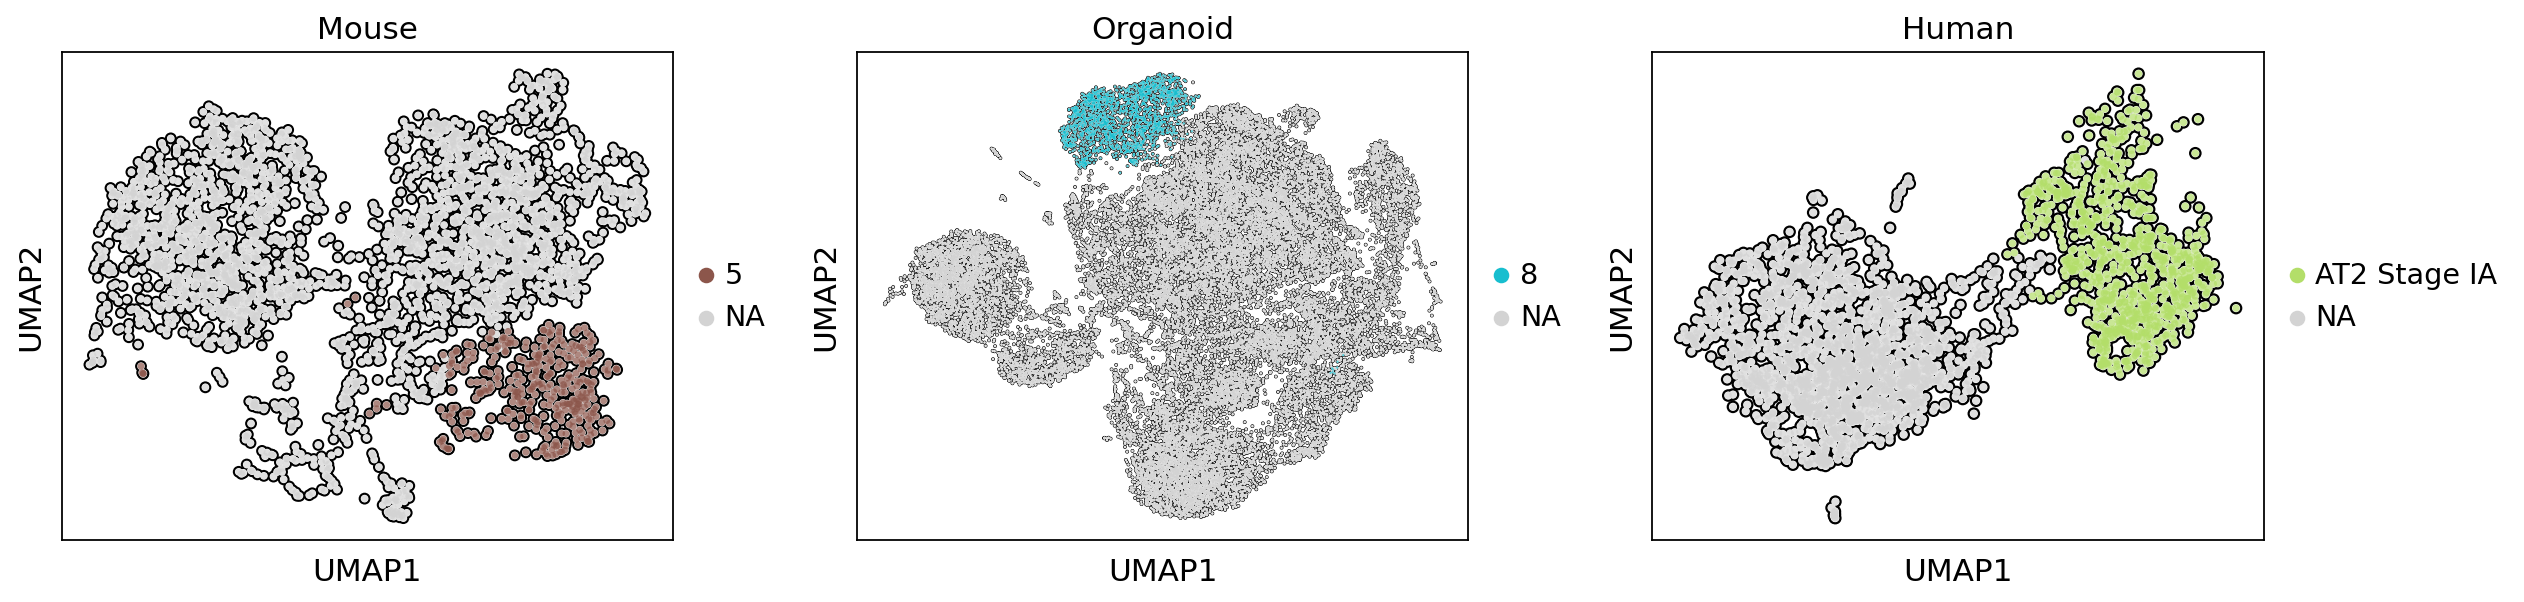

In [50]:
# Create a figure and a grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,4))

sc.set_figure_params(figsize=(4,3))

# Plot the UMAP plots
sc.pl.umap(mouse, color=['cell_annotations'], groups = ['5'], add_outline=True, frameon=True, ax=axes[0], show=False, title='Mouse')
sc.pl.umap(orgs, color=['leiden0_2'], groups = ['8'], add_outline=True, frameon=True, ax=axes[1], show=False, title = 'Organoid')
sc.pl.umap(human, color=['annot'], groups = ['AT2 Stage IA'], add_outline=True, frameon=True, ax=axes[2], show=False, title = 'Human')

# Display the figure
plt.tight_layout()
plt.show()

In [49]:
# Define the keys
key1 = 'Human cluster AT2 Stage IA receptors'
key2 = 'Mouse cluster 5 receptors'
key3 = 'Organoid cluster 8 receptors'

# Make sure the keys are in the dictionary
if key1 in rec_dict and key2 in rec_dict and key3 in rec_dict:
    # Convert the lists to sets, uppercase for set2 and set3
    set1 = set(rec_dict[key1])
    set2 = {gene.upper() for gene in rec_dict[key2]}
    set3 = {gene.upper() for gene in rec_dict[key3]}

    # Find the intersection
    common_genes = set1.intersection(set2, set3)
    
    print("Common genes:", common_genes)
else:
    print("One or more keys are not in the dictionary")

Common genes: {'OCLN', 'ITGA3', 'ADIPOR1', 'PLXNB2', 'CLDN4', 'ST14', 'ITGB1', 'LSR'}


### Plot heatmaps using conserved receptors

#### Organoids

Scaling and copying expression matrix
True
Selecting genes and pathways of interest
# Genes and pathways used: 8


<Figure size 1200x900 with 0 Axes>

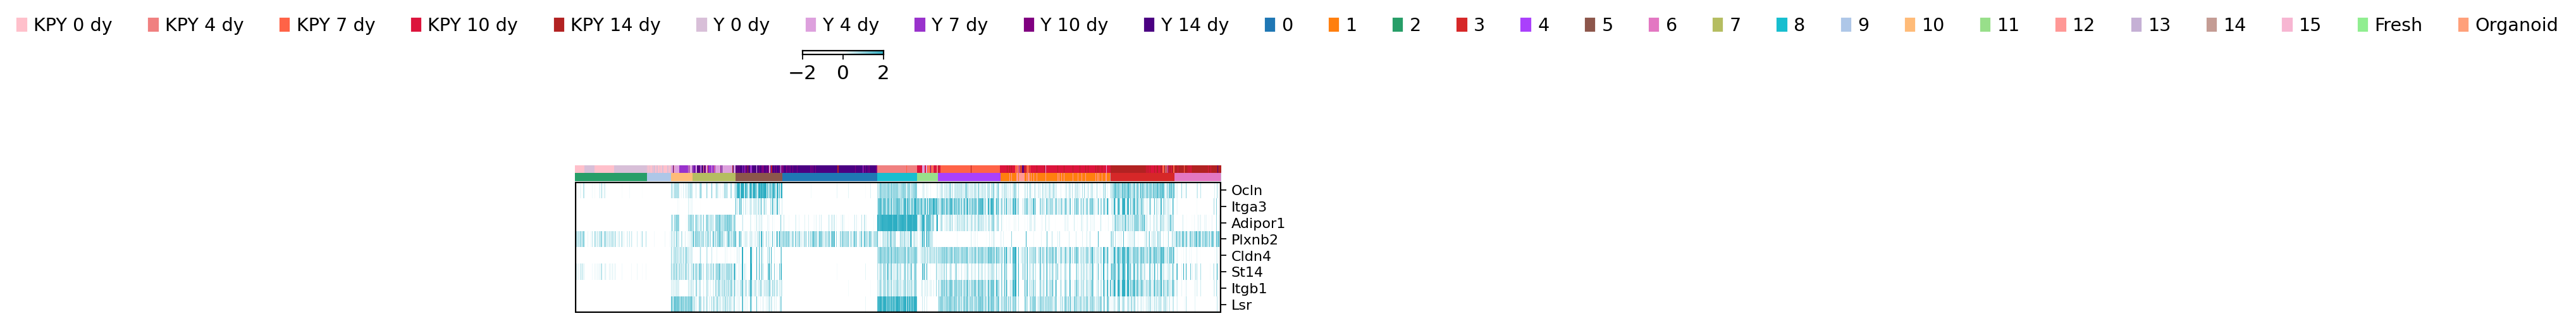

In [56]:
# Scale and create dataframe
print('Scaling and copying expression matrix')
scaled = sc.pp.scale(orgs, copy=True)
input_df = pd.DataFrame(data=scaled.X, index=scaled.obs_names, columns=scaled.var_names)

df = input_df.copy()

# QC
print(len(df.columns) == len(orgs.var_names))

# Add pathways 
pathways=['leiden0_2','yfp_time_annot','fresh_org_annot'] 
genes = ['Ocln', 'Itga3', 'Adipor1', 'Plxnb2', 'Cldn4', 'St14', 'Itgb1', 'Lsr'] # conserved early-stage receptors
paths_of_interest = [] # If pathway isn't here IT WILL BE REMOVED

for path in pathways:
    df[path]=scaled.obs[path]

# manually order the dataframe using a numeric strategy
input2 = df['leiden0_2'].astype('object')
sorterIndex = {'2':'0',
               '15':'1',
               '9':'2',
               '10':'3',
               '7':'4',
               '5':'5',
               '0':'6',
               '8':'7',
               '11':'8',
               '4':'9',
               '1':'99',
               '12':'99',
               '14':'999',
               '3':'9999',
               '6':'99999',
               '13':'999999'}
results = input2.map(sorterIndex)
df['order_results'] = results # creates row with numeric values that can be sorted
df = df.sort_values(['order_results'], ascending = True) # reorder the dataframe

# Color annotations
# time point colors
color_input = df['yfp_time_annot'].astype('object')

lut = {
'KPY 0 dy':'pink','KPY 4 dy':'lightcoral','KPY 7 dy':'tomato','KPY 10 dy':'crimson','KPY 14 dy':'firebrick',
'Y 0 dy':'thistle','Y 4 dy':'plum','Y 7 dy':'darkorchid','Y 10 dy':'purple','Y 14 dy':'indigo'}

col_colors = color_input.map(lut)

# cluster colors
color_input2 = df['leiden0_2'].astype('object')
lut2 = {'0': '#1f77b4',
 '1': '#ff7f0e',
 '2': '#279e68',
 '3': '#d62728',
 '4': '#aa40fc',
 '5': '#8c564b',
 '6': '#e377c2',
 '7': '#b5bd61',
 '8': '#17becf',
 '9': '#aec7e8',
 '10': '#ffbb78',
 '11': '#98df8a',
 '12': '#ff9896',
 '13': '#c5b0d5',
 '14': '#c49c94',
 '15': '#f7b6d2'}
col_colors2 = color_input2.map(lut2)

# fresh/organoid colors
color_input3 = df['fresh_org_annot'].astype('object')
lut3 = {'Fresh':'lightgreen','Organoid':'lightsalmon'}
col_colors3 = color_input3.map(lut3)

# Remove columns that are not gene expression
df_input = df.drop(['leiden0_2','yfp_time_annot','order_results','fresh_org_annot'], axis=1)
df_input = df_input.T # makes cells columns

print('Selecting genes and pathways of interest')
inpt = genes + paths_of_interest
df1 = df_input.loc[inpt] 
print('# Genes and pathways used:', len(df1.index))

# Plot clustermap
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sb
import matplotlib.patches as mpatches

vmin = -2  # expression
vmax = 2  # expression
base = 4 # for plot size, not expression

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['white', 'white', '#2DAEC3'])

plt.figure(dpi=300)

g1 = sb.clustermap(
    df1, vmin=vmin, vmax=vmax, center=0,
    cmap=cmap, metric="euclidean", row_cluster=False, col_cluster=False,
    figsize=(8, len(df1.index) / base), cbar_pos=(0.35, 1.4, .1, .02),  # locxaxis,locyaxis,cbarwidth,cbarheight
    col_colors=[col_colors, col_colors2], yticklabels=True, xticklabels=False,
    cbar_kws={"orientation": "horizontal"},
    dendrogram_ratio=0.05, colors_ratio=0.05
)

ax = g1.ax_heatmap
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_xlabel("")
ax.set_ylabel("", rotation=270, labelpad=25)
ax.tick_params(axis='y', which='major', labelsize=10)
ax.axhline(y=0, color='black', linewidth=2)  # border
ax.axhline(y=len(df1.index), color='black', linewidth=2)  # border
ax.axvline(x=0, color='black', linewidth=2)  # border
ax.axvline(x=len(df1.columns), color='black', linewidth=2)  # border

# Create a list to collect the patches
patches = []

# Create a patch for every color
for key in lut.keys():
    patches.append(mpatches.Patch(color=lut[key], label=key))

# Add patches for col_colors2
for key in lut2.keys():
    patches.append(mpatches.Patch(color=lut2[key], label=key))
    
# Add patches for col_colors3
for key in lut3.keys():
    patches.append(mpatches.Patch(color=lut3[key], label=key))

# Add legends for col_colors and col_colors2
plt.legend(handles=patches, bbox_to_anchor=(1, 1, 10, 10), loc='upper center', ncol=len(patches), borderaxespad=0, frameon=False)

# Get the colorbar axes
cbar_ax = g1.cax

# Add a border around the colorbar
cbar_ax.spines['top'].set_visible(True)
cbar_ax.spines['bottom'].set_visible(True)
cbar_ax.spines['left'].set_visible(True)
cbar_ax.spines['right'].set_visible(True)
cbar_ax.spines['top'].set_linewidth(1)
cbar_ax.spines['bottom'].set_linewidth(1)
cbar_ax.spines['left'].set_linewidth(1)
cbar_ax.spines['right'].set_linewidth(1)

plt.show()

### Human

Scaling and copying expression matrix
QC: PASS - assembled df has a gene length equal to the original anndata
Adding pathway and genes
Adding color map
Selecting genes and pathways of interest
# Genes and pathways used: 8
PASS: No non-numeric data found in the dataframe.


<Figure size 1200x900 with 0 Axes>

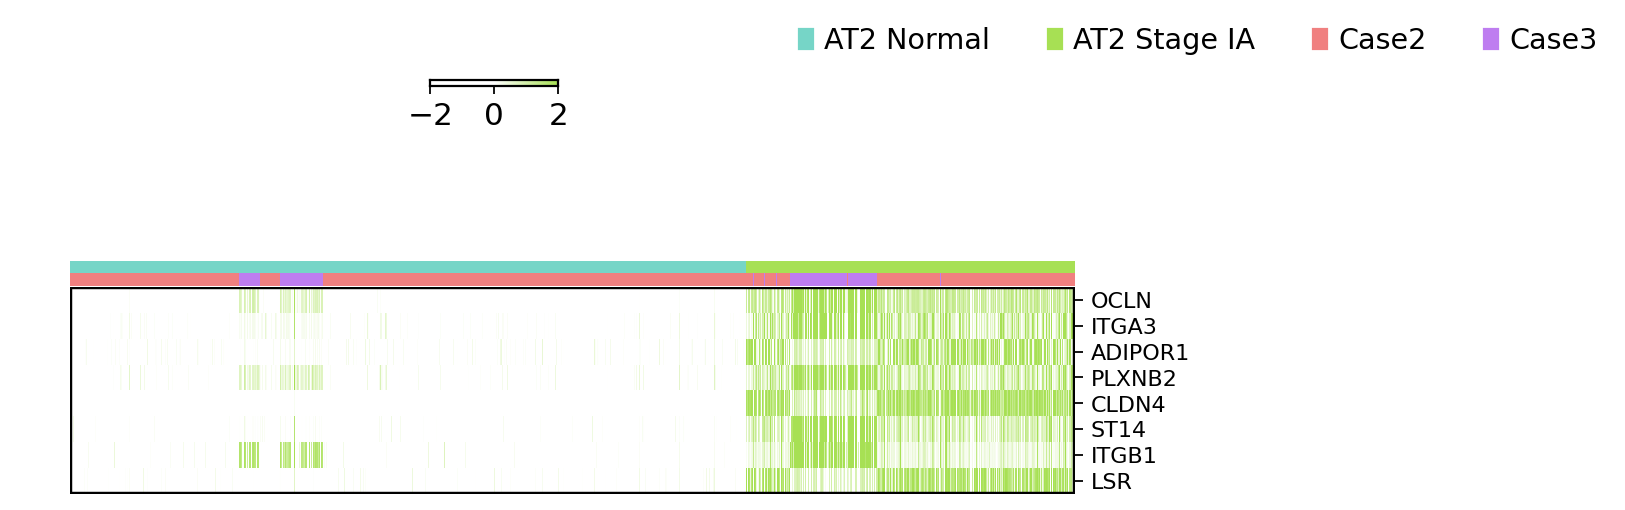

In [65]:
# Scale and create dataframe
print('Scaling and copying expression matrix')

scaled = sc.pp.scale(human, copy=True)
input_df = pd.DataFrame(data=scaled.X, index=scaled.obs_names, columns=scaled.var_names)
df = input_df.copy()

# QC
if len(df.columns) == len(scaled.var_names):
    print('QC: PASS - assembled df has a gene length equal to the original anndata')
else:
    print('QC: FAIL - assembled df gene length IS NOT EQUAL to the original anndata')


# Add pathways 
print('Adding pathway and genes')

pathways=['annot', 'case'] 

# Filter genes of interest not in adata.var_names
genes = ['OCLN', 'ITGA3', 'ADIPOR1', 'PLXNB2', 'CLDN4', 'ST14', 'ITGB1', 'LSR']

paths_of_interest = [] # If pathway isn't here IT WILL BE REMOVED

for path in pathways:
    df[path]=scaled.obs[path]

# manually order the dataframe using a numeric strategy
input2 = df['annot'].astype('object')
sorterIndex = {'AT2 Normal': '0',
               'AT2 Stage IA': '1',
              }

results = input2.map(sorterIndex)
df['order_results'] = results # creates row with numeric values that can be sorted
df = df.sort_values(['order_results'], ascending = True) # reorder the dataframe

# Color annotations
print('Adding color map')

# time point colors
color_input = df['annot'].astype('object')

lut = {'AT2 Normal': '#76D5C7',
      'AT2 Stage IA': '#A7E054',
      }

col_colors = color_input.map(lut)

# cluster colors
color_input2 = df['case'].astype('object')
lut2 = {
 'Case2': 'lightcoral',
 'Case3': '#be7df0'
       }
col_colors2 = color_input2.map(lut2)

# Remove columns that are not gene expression
df_input = df.drop(['annot','case'], axis=1)
df_input = df_input.T # makes cells columns

print('Selecting genes and pathways of interest')
inpt = genes + paths_of_interest
df1 = df_input.loc[inpt] 
print('# Genes and pathways used:', len(df1.index))
df1 = df1.fillna(0) # turn NaN into 0 since there is no gene expression

# QC
# Check for non-numeric data
non_numeric = df1.applymap(lambda x: not isinstance(x, (int, float)))
if non_numeric.sum().sum() > 0:
    print("FAIL: Non-numeric data found in the dataframe.")
else:
    print("PASS: No non-numeric data found in the dataframe.")

# Plot clustermap
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sb
import matplotlib.patches as mpatches

vmin = -2  # expression
vmax = 2  # expression
base = 4 # for plot size, not expression

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['white', 'white', '#A7E054'])

plt.figure(dpi=300)

g1 = sb.clustermap(
    df1, vmin=vmin, vmax=vmax, center=0,
    cmap=cmap, metric="euclidean", row_cluster=False, col_cluster=False,
    figsize=(8, len(df1.index) / base), cbar_pos=(0.35, 1.4, .1, .02),  # locxaxis,locyaxis,cbarwidth,cbarheight
    col_colors=[col_colors, col_colors2], yticklabels=True, xticklabels=False,
    cbar_kws={"orientation": "horizontal"},
    dendrogram_ratio=0.05, colors_ratio=0.05
)

ax = g1.ax_heatmap
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_xlabel("")
ax.set_ylabel("", rotation=270, labelpad=25)
ax.tick_params(axis='y', which='major', labelsize=10)
ax.axhline(y=0, color='black', linewidth=2)  # border
ax.axhline(y=len(df1.index), color='black', linewidth=2)  # border
ax.axvline(x=0, color='black', linewidth=2)  # border
ax.axvline(x=len(df1.columns), color='black', linewidth=2)  # border

# Create a list to collect the patches
patches = []

# Create a patch for every color
for key in lut.keys():
    patches.append(mpatches.Patch(color=lut[key], label=key))

# Add patches for col_colors2
for key in lut2.keys():
    patches.append(mpatches.Patch(color=lut2[key], label=key))

# Add legends for col_colors and col_colors2
plt.legend(handles=patches, bbox_to_anchor=(1, 1, 10, 10), loc='upper center', ncol=len(patches), borderaxespad=0, frameon=False)

# Get the colorbar axes
cbar_ax = g1.cax

# Add a border around the colorbar
cbar_ax.spines['top'].set_visible(True)
cbar_ax.spines['bottom'].set_visible(True)
cbar_ax.spines['left'].set_visible(True)
cbar_ax.spines['right'].set_visible(True)
cbar_ax.spines['top'].set_linewidth(1)
cbar_ax.spines['bottom'].set_linewidth(1)
cbar_ax.spines['left'].set_linewidth(1)
cbar_ax.spines['right'].set_linewidth(1)

plt.show()

### GEMM

<Figure size 1200x900 with 0 Axes>

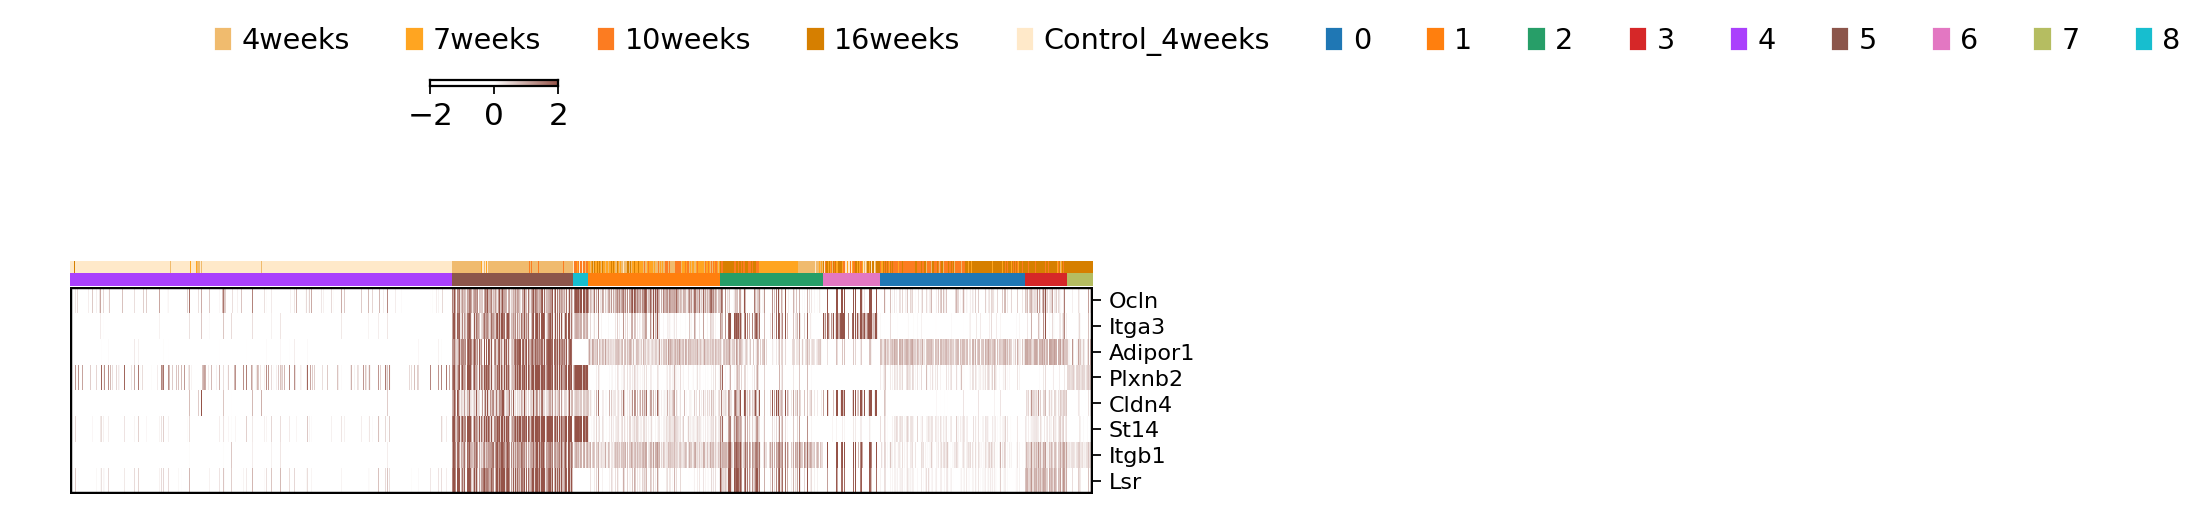

In [59]:
# copy data 
cancer_df = sc.pp.scale(mouse, copy=True)

df = pd.DataFrame(index=mouse.obs.index)

# Add col color annotations to the dataframe. Will also add an index. Two for one!
pathways=['cell_annotations','time_point'] 
genes = ['Ocln', 'Itga3', 'Adipor1', 'Plxnb2', 'Cldn4', 'St14', 'Itgb1', 'Lsr'] # conserved early-stage receptors

# Add pathways first for index
for path in pathways:
    df[path]=cancer_df.obs[path]
 
for gene in genes:
    df[gene]=cancer_df[:, [gene]].to_df()

cols = pathways + genes
df = df[cols]

# order dataframe rows based on time point contribution
input2 = df['cell_annotations'].astype('object')
sorterIndex = {'4':'0',
               '5':'1',
               '8':'2',
               '1':'3',
               '2':'4',
               '6':'5',
               '0':'6',
               '3':'7',
               '7':'8'}
results = input2.map(sorterIndex)
df['order_results'] = results
df = df.sort_values(['order_results'], ascending = True) # reorder the dataframe

# Color annotations
color_input = df['time_point'].astype('object')
lut = {'4weeks':'#f0bb6e','7weeks':'#ffa521','10weeks':'#fc7c21','16weeks':'#d67f00','Control_4weeks':'#ffe9c9'}
col_colors = color_input.map(lut)

color_input2 = df['cell_annotations'].astype('object')
lut2 = dict(zip(sorted(color_input2.unique()), mouse.uns['cell_annotations_colors'])) 
col_colors2 = color_input2.map(lut2)

# Remove columns that are not gene expression
df = df.drop(['cell_annotations','time_point','order_results'], axis=1)
df = df.T # makes cells columns

# Plot
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sb
import matplotlib.patches as mpatches

vmin = -2  # expression
vmax = 2  # expression
base = 4 # for plot size, not expression

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['white', 'white', '#955348'])

plt.figure(dpi=300)

g1 = sb.clustermap(
    df, vmin=vmin, vmax=vmax, center=0,
    cmap=cmap, metric="euclidean", row_cluster=False, col_cluster=False,
    figsize=(8, len(df.index) / base), cbar_pos=(0.35, 1.4, .1, .02),  # locxaxis,locyaxis,cbarwidth,cbarheight
    col_colors=[col_colors, col_colors2], yticklabels=True, xticklabels=False,
    cbar_kws={"orientation": "horizontal"},
    dendrogram_ratio=0.05, colors_ratio=0.05
)

ax = g1.ax_heatmap
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_xlabel("")
ax.set_ylabel("", rotation=270, labelpad=25)
ax.tick_params(axis='y', which='major', labelsize=10)
ax.axhline(y=0, color='black', linewidth=2)  # border
ax.axhline(y=len(df.index), color='black', linewidth=2)  # border
ax.axvline(x=0, color='black', linewidth=2)  # border
ax.axvline(x=len(df.columns), color='black', linewidth=2)  # border

# Create a list to collect the patches
patches = []

# Create a patch for every color
for key in lut.keys():
    patches.append(mpatches.Patch(color=lut[key], label=key))

# Add patches for col_colors2
for key in lut2.keys():
    patches.append(mpatches.Patch(color=lut2[key], label=key))
    
# Add legends for col_colors and col_colors2
plt.legend(handles=patches, bbox_to_anchor=(1, 1, 10, 10), loc='upper center', ncol=len(patches), borderaxespad=0, frameon=False)

# Get the colorbar axes
cbar_ax = g1.cax

# Add a border around the colorbar
cbar_ax.spines['top'].set_visible(True)
cbar_ax.spines['bottom'].set_visible(True)
cbar_ax.spines['left'].set_visible(True)
cbar_ax.spines['right'].set_visible(True)
cbar_ax.spines['top'].set_linewidth(1)
cbar_ax.spines['bottom'].set_linewidth(1)
cbar_ax.spines['left'].set_linewidth(1)
cbar_ax.spines['right'].set_linewidth(1)

plt.show()